<a href="https://colab.research.google.com/github/hongsunjang/hands-on-ML/blob/main/Chatper3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

from sklearn.datasets import fetch_openml

# as_frame옵션이 추가되어서 dict형태로 받고싶다면 이렇게 해야한다.
mnist = fetch_openml('mnist_784', version = 1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X , y = mnist['data'], mnist['target']
X.shape

(70000, 784)

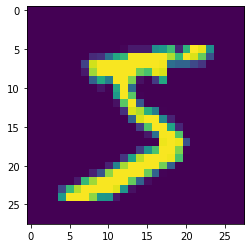

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image)
plt.show()


In [9]:
type(y[0])

str

In [10]:
import numpy as np
y = y.astype(np.uint8)

In [11]:
# MNIST 데이터셋은 이미 split이 되어있기 때문에 이렇게 하는 것이다.
X_train, X_test , y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 대표적인 Binary classifier 로 해보자

In [12]:
# Label을 5인지 아닌지를 판별하기위한 레이블로 변환한다.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf  = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# sklearn의 cross_val_score로 성능측정 
=> 폴드가 3개인 k-겹 교차검증을 해준다.

## 만약 직접 구현하고 싶다면 StratifiedKFold로 3개인 k-겹 교차검증을 직접 구현해보자

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits= 3 , random_state = 42, shuffle =True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold) # 성능측정
  print(n_correct / len(y_pred))

0.09735
0.09415
0.0978


# 성능이 굉장히 좋다! => 그렇지 않다.
모든 결과를 false로 예측하는 모델을 만들어서 성능을 보자


In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier (BaseEstimator):
  def fit(self, X, y = None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [17]:
never_5_clf = Never5Classifier()
# 쉽게 cross_val_score를 사용해서 구할 수도 있다.
from sklearn.model_selection import cross_val_score
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring= 'accuracy')

array([0.91125, 0.90855, 0.90915])

# Confusion matrix를 활용해야한다

In [18]:
from sklearn.model_selection import cross_val_predict

# cross_val_score와 달리 교차검증을 수행하지만 테스트 폴드에서 얻은 예측결과를 반환한다.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# confusion_matrix를 잘 기억하자

array([[53892,   687],
       [ 1891,  3530]])

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# SGDClassifier의 동작
1. Decision function을 사용해서 샘플의 점수를 계산합니다.
2. decision threshold를 결정해서 분류합니다.
=> 임계값을 올리면 precision은 올라가고 recall은 떨어집니다.
=> 임계값을 낮추면 precision은 내려가지만 recall은 올라갑니다

In [23]:
# sklearn에서 SGDClassifier에 사용하는 threshold를 직접 변경할 수는없지만
# predict대신 decision function의 결과 score를 얻어내서 맘대로 threshold를 조정할 수 있습니다.

# 예측값대신 교차검증으로 얻어낸 decision function을 얻습니다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')


In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

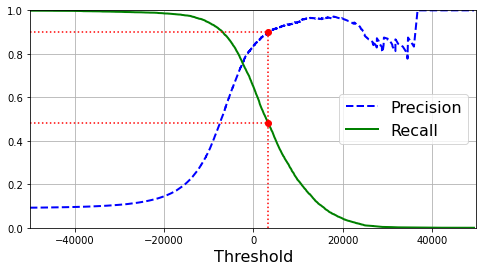

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

# ROC 곡선! FPR, TPR 개념 중요

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

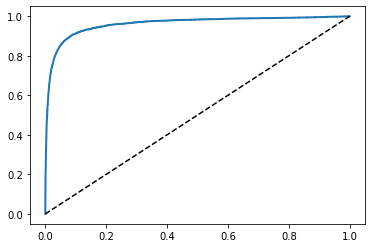

In [27]:
def plot_roc_curve (fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth =2 , label = label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)


In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# multi class에서 오차 분석

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train , cv = 3)
conf_mx = confusion_matrix(y_train, y_train)
conf_mx
                          

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

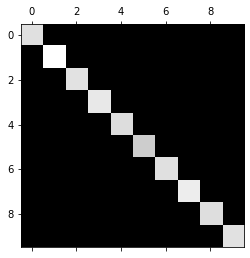

In [30]:
plt.matshow(conf_mx, cmap= plt.cm.gray)
plt.show()

In [35]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx /row_sums # 각 값에 대응되는 클래스의 이미지 개수가 다르므로 이미지 개수로 나눠준다

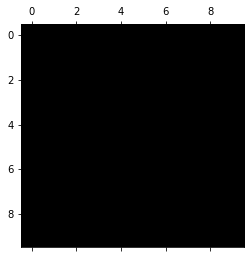

In [36]:
np.fill_diagonal(norm_conf_mx, 0) # 주 대각선은 잘분류한 경우이므로 지워준다
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# 다중 label 분류

In [33]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

                     


KNeighborsClassifier()

In [34]:
knn_clf.predict([some_digit])


array([[False,  True]])

In [37]:
# 분류 방법은 간단하게 f1_score의 평균을 내는 방법이 있다.

y_train_knn_pred = cross_val_predict ( knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# 다중 출력 다중 클래스 분류( 노이즈 제거)

In [40]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise =np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


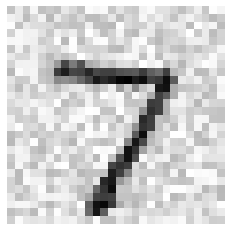

In [51]:
plot_digit(X_test_mod[0])

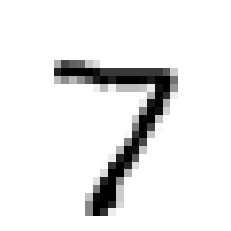

In [50]:

plot_digit(y_test_mod[0])

In [46]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

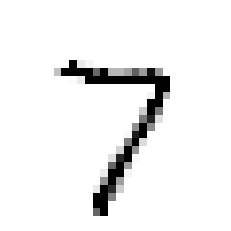

In [47]:
knn_clf.fit(X_train_mod , y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)